In [1]:
import sys
if (path := "C:/Users/Tom/PycharmProjects/python-hvac") not in sys.path:
    sys.path.append(path)

In [2]:
from datetime import date

import numpy as np
import control as ct
import pandas as pd

from hvac import Quantity, print_doc_string
from hvac.charts import LineChart
from hvac.sun import Location, ClimateType
from hvac.cooling_load_calc import WeatherData

from thermal_zone_example import create_zone

Q_ = Quantity

# 7. Free-Floating Zone Air Temperature
---

The normally intended usage of package `hvac.cooling_load_calc` will be for estimating the cooling/heating load or the thermal energy need of a thermal building zone, as has been demonstrated in the previous notebook no. 6. For this, a call to  method `simulate(...)` of the `ThermalZone` object is generally sufficient. However, it is also possible to create the network model and its state-space representation (system) outside of the `ThermalZone` object. In this notebook we will simulate the course of the zone-air temperature on a certain selected day with the HVAC-system turned off (i.e. without temperature control of the zone-air temperature).

## Modeling the Thermal Zone

First we create again the same thermal zone from the previous notebook no. 6 (see `thermal_zone_example.py`)

In [3]:
location = Location(
    fi=Q_(51.183, 'deg'),
    L_loc=Q_(3.8, 'deg'),
    altitude=Q_(8, 'm'),
    climate_type=ClimateType.MID_LATITUDE_SUMMER,
    timezone='Etc/GMT-1'
)

For the weather data, we will use TMY data here. To read a TMY file, class `TMY` in module `sun.tmy.py` is used. The implementation of this class is based on the format of csv-files like the ones that can be downloaded from [PVGIS](https://re.jrc.ec.europa.eu/pvg_tools/en/#api_5.2). This means that date and time are written together in a single column, which must also be the first column of the csv-file. Furthermore, the csv-file must only contain the real TMY-data (other rows or columns must be deleted from the csv-file).

In [4]:
print_doc_string(WeatherData.create_from_tmy_data)

Creates a `WeatherData` object from TMY-data saved in a csv-file.

Parameters
----------
location:
    Geographic location for which the weather data is valid.
date:
    Date for which the weather data is valid.
tmy_file:
    Path to the csv-file with hourly TMY data.
tmy_params:
    2-tuple with the date-time format used in the csv-file and the
    timezone in which the date-times are expressed in the csv-file,
    using the tz-database notation.
    (https://en.wikipedia.org/wiki/List_of_tz_database_time_zones).

Parameter Types & Defaults
--------------------------
location: 'Location'
date: 'Date'
tmy_file: 'PathLike'
tmy_params: 'tuple[str, str]' = ('%Y%m%d:%H%M', 'UTC')


In [5]:
weather_data = WeatherData.create_from_tmy_data(
    location=location,
    date=date(2000, 6, 21),  # <- selected day
    tmy_file="./tmy_data/tmy_50.911_3.192_2005_2020.csv"
)

In [6]:
thz = create_zone(weather_data, T_int_des=Q_(22, 'degC'))

## Thermal Zone Network and State-Space Model (System)

Now, we can create the zone's thermal network model:

In [7]:
thz_model = thz.create_model()

And from the thermal zone's network model, we will create its state-space representation (instance of `control.StateSpace`) by calling method `create_system(...)`.

In [8]:
print_doc_string(thz_model.create_system)

Creates the system of the linear thermal network in state-space 
representation.

Parameters
----------
output_nodes:
    Nodes in the linear thermal network whose temperature will be the 
    output of the system. If `None`, the last node in the `nodes` list
    is taken to be the output node.
reduced_order:
    The order to which the system should be reduced. If `None`, the 
    order of the system won't be reduced.
    As the system is build from a big number of temperature nodes, the
    system order will also be high. However, without noticeable loss of 
    accuracy, the order can normally be reduced to an order of 8 or 6
    (but not below the number of system outputs; should `reduced_order`
    be less than the number of system outputs, it will be limited to the
    number of system outputs). 
    Note that without system reduction, it may also happen that some 
    internal mathematical operations raise an exception (e.g. 
    `FloatingPointError`).

Returns
-------
`ct.StateS

In [9]:
thz_system = thz_model.create_system(reduced_order=8)

The object `thz_system` is an object coming from third-party package `python-control` ([Python Control Systems Library](https://github.com/python-control/python-control)). This package is used to solve the thermal zone model, i.e. to determine the temperatures of the nodes in the thermal network model (see also "Some Supplementary Background" in the previous notebook no. 6).

## Simulation

Before we can actually run a simulation, we need to collect the input data for the simulation from the thermal zone model `thz` (sol-air temperatures at the exterior building elements, exterior outdoor air dry-bulb temperature, radiative and convective heat gains in the zone).

In [10]:
print_doc_string(thz.collect_input_data)

Returns all the input data that is needed for running a simulation of
the zone system.

Parameters
----------
num_cycles:
    The number of days the selected (design) day needs to be repeated 
    before the simulation ends. When the simulation starts, the initial 
    values of all system state variables are set to zero, and the daily,
    24h cycle of system input values needs to be repeated a number of 
    days until the system shows a harmonic periodic behavior in time or 
    the zone-air temperature 'T_za' has settled around the setpoint. 
setpoint:
    Setpoint of the zone-air temperature (a fixed value). If set to 
    `None`, the setpoint is ignored and the HVAC-system is considered to
    be turned off.

Returns
-------
time:
    Numpy 1D-array holding the timeline for the simulation. The timeline
    counts the hours of `num_cycles` successive days (the selected
    design day repeats itself `num_cycles` times). 
input_data: dict[str, Quantity]
    The keys of the dictionar

In [11]:
time, input_data = thz.collect_input_data(num_cycles=20)

In [12]:
for key in input_data.keys():
    print(key)

Q_gain_rad@zone_1
Q_gain_conv@zone_1
T_sa@ew_W
T_sa@ew_S
T_sa@ew_E
T_sa@ed_E1
T_sa@rf_S
T_ext_db@zone_1
T_za@zone_2


The input data that we have collected must be arranged in the same order as the order of the inputs expected by the state-space model `thz_system`.

In [13]:
for input_label in thz_system.input_labels:
    print(input_label)

T_sa@ew_W
T_sa@ew_S
T_sa@ew_E
T_sa@rf_S
T_ext_db@zone_1
T_sa@ed_E1
T_za@zone_2
Q_gain_rad@zone_1
Q_gain_conv@zone_1
Q_hvac@zone_1


To arrange the inputs for the state-space model `thz_system` in the correct order, we first create a zero-matrix of which the number of rows equals the number of inputs in the state-space model. The number of columns equals the number of values for each input (this number is equal to the number of hours in a day, as the simulation happens on a hourly basis). Then, we use the `input_index` dictionary of `thz_system` to retrieve the correct row index for the current input name, and we assign the values in `input_data` to this row. 

In [14]:
inputs = np.zeros((len(thz_system.input_labels), len(time)))
for input_name, input_values in input_data.items():
    row_index = thz_system.input_index[input_name]
    inputs[row_index, :] = input_values.magnitude

In [15]:
df_inputs = pd.DataFrame(data=inputs, index=thz_system.input_labels)
df_inputs

,0,1,2,3,4,5,6,7,8,9,...,470,471,472,473,474,475,476,477,478,479
T_sa@ew_W,287.890000,287.780000,287.700000,287.569819,288.064413,290.220121,292.398603,296.339612,300.758901,301.265940,...,300.615212,298.282579,295.037952,292.854963,292.786859,290.524731,289.003643,287.570000,286.880000,286.470000
T_sa@ew_S,287.890000,287.780000,287.700000,287.573908,287.944723,289.955160,292.192359,296.228889,301.377575,302.835799,...,301.127344,298.349430,295.039260,292.854963,292.786859,290.524731,289.002205,287.570000,286.880000,286.470000
T_sa@ew_E,287.890000,287.780000,287.700000,287.574162,287.944723,289.955160,292.149806,296.033313,299.526039,300.465362,...,300.779509,298.353679,295.085437,292.900101,292.925285,290.686747,288.979022,287.570000,286.880000,286.470000
T_sa@rf_S,284.512501,284.402501,284.322501,284.201610,284.920698,287.889698,290.959025,296.203272,304.123080,306.261031,...,302.238493,297.162741,292.990471,290.384110,290.363613,287.557247,285.627766,284.192501,283.502501,283.092501
T_ext_db@zone_1,287.890000,287.780000,287.700000,287.560000,287.450000,288.110000,289.250000,291.690000,292.840000,293.030000,...,294.880000,295.300000,293.200000,291.600000,291.450000,289.950000,288.960000,287.570000,286.880000,286.470000
T_sa@ed_E1,287.890000,287.780000,287.700000,287.574162,287.944723,289.955160,292.149806,296.033313,299.526039,300.465362,...,300.779509,298.353679,295.085437,292.900101,292.925285,290.686747,288.979022,287.570000,286.880000,286.470000
T_za@zone_2,301.150000,301.150000,301.150000,301.150000,301.150000,301.150000,301.150000,301.150000,301.150000,301.150000,...,301.150000,301.150000,301.150000,301.150000,301.150000,301.150000,301.150000,301.150000,301.150000,301.150000
Q_gain_rad@zone_1,0.000000,0.000000,0.000000,2.081459,90.742231,338.314952,537.920238,824.541347,1596.672230,1805.901997,...,1346.580130,776.467382,557.070610,449.874767,251.666411,112.997391,4.674887,0.000000,0.000000,0.000000
Q_gain_conv@zone_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.500000,94.500000,...,157.500000,157.500000,157.500000,157.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Q_hvac@zone_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


It should be noted that the last row, input `"Q_hvac@zone_1"`, is still a row of zeros. An input value of zero means that the HVAC-system doesn't supply or extract any heat from the zone, so the zone-air temperature will be free-floating, only depending on the heat gains in the zone.

Run the simulation. For this, we will use the function `forced_response(...)` from third-party package `python-control` (which we have imported at the head of this notebook as `ct`). This function will return a `TimeResponseData` object.

In [16]:
resp = ct.forced_response(thz_system, time, inputs)

In [20]:
print(resp.input_labels)

['T_sa@ew_W', 'T_sa@ew_S', 'T_sa@ew_E', 'T_sa@rf_S', 'T_ext_db@zone_1', 'T_sa@ed_E1', 'T_za@zone_2', 'Q_gain_rad@zone_1', 'Q_gain_conv@zone_1', 'Q_hvac@zone_1']


In [21]:
print(resp.inputs)

[[287.89 287.78 287.7  ... 287.57 286.88 286.47]
 [287.89 287.78 287.7  ... 287.57 286.88 286.47]
 [287.89 287.78 287.7  ... 287.57 286.88 286.47]
 ...
 [  0.     0.     0.   ...   0.     0.     0.  ]
 [  0.     0.     0.   ...   0.     0.     0.  ]
 [  0.     0.     0.   ...   0.     0.     0.  ]]


In [22]:
print(resp.output_labels)

['T_za@zone_1']


In [23]:
print(resp.outputs)

[[1.22930576e-02 2.95103600e+01 3.48691518e+01 3.98348078e+01
  4.48125248e+01 4.99633170e+01 5.52728541e+01 6.07673014e+01
  6.63831749e+01 7.19026275e+01 7.73404955e+01 8.27979871e+01
  8.84172222e+01 9.38356326e+01 9.87849904e+01 1.03719207e+02
  1.08319871e+02 1.12767581e+02 1.16995732e+02 1.21118027e+02
  1.25133440e+02 1.28995924e+02 1.32786033e+02 1.36494741e+02
  1.40240438e+02 1.43815885e+02 1.47292652e+02 1.50678102e+02
  1.53988418e+02 1.57301914e+02 1.60625510e+02 1.64031351e+02
  1.67498625e+02 1.70841831e+02 1.74098362e+02 1.77384653e+02
  1.80853054e+02 1.84147936e+02 1.87005847e+02 1.89884005e+02
  1.92466278e+02 1.94934789e+02 1.97223900e+02 1.99447848e+02
  2.01605814e+02 2.03651704e+02 2.05665829e+02 2.07638773e+02
  2.09688425e+02 2.11606960e+02 2.13465304e+02 2.15270126e+02
  2.17036894e+02 2.18843180e+02 2.20695151e+02 2.22664197e+02
  2.24728749e+02 2.26702550e+02 2.28622248e+02 2.30603536e+02
  2.32798036e+02 2.34849403e+02 2.36493477e+02 2.38186784e+02
  2.3961

Only keep the values of the last 24 hours of the simulation. We just take the outdoor air temperature `T_ext_db` (at row index 4) from the inputs, and the zone-air temperature `T_za` from the outputs (which is the only output).

In [17]:
time = [h for h in range(24)]
T_ext_db = Q_(resp.inputs[4, -24:].flatten(), 'K')
T_za = Q_(resp.outputs[:, -24:].flatten(), 'K')

Plot of the outdoor air dry-bulb temperature and the zone-air temperature together on one line chart:

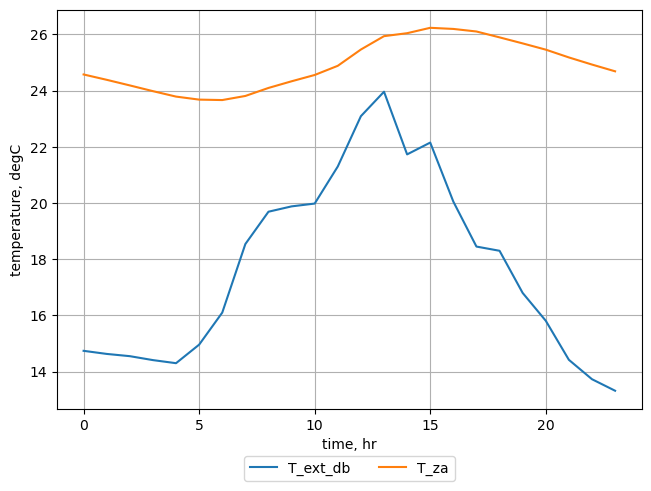

In [18]:
chart = LineChart()
chart.add_xy_data(
    label='T_ext_db',
    x1_values=time,
    y1_values=T_ext_db.to('degC').m,
)
chart.add_xy_data(
    label='T_za',
    x1_values=time,
    y1_values=T_za.to('degC').m
)
chart.x1.add_title('time, hr')
chart.y1.add_title('temperature, degC')
chart.add_legend()
chart.show()